In [1]:
import os
import matplotlib.pyplot as plt
%matplotlib widget
import cv2
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from analysis_utils import *

import joblib
parallel = joblib.Parallel(n_jobs=4)

In [2]:
video_selection = '49b1r' #'49b1r_post_merge'

if video_selection == '25b25r-1':
    nDrops             = 50
    xmin, ymin, xmax, ymax = 95, 30, 535, 470    
    pxDimension = 90/500 # 9cm is the petri dish --> 90mm
    red_particle_idx = np.sort(np.array([38, 42, 25, 4, 23, 13, 45, 33, 46, 29, 10, 3, 35, 18, 12, 0, 27, 19, 26, 47, 7, 48, 21, 20, 22], dtype=int))
    original_trajectories = pd.read_parquet('../tracking/25b25r-1/modified_2D_versatile_fluo/interpolated_tracking_25b25r-1_modified_2D_versatile_fluo_0_539999.parquet')
    original_trajectories.r = original_trajectories.r * pxDimension
    original_trajectories = original_trajectories.loc[:, ['x', 'y', 'r', 'frame', 'particle', 'color']]

elif video_selection == '49b1r':
    nDrops             = 50
    xmin, ymin, xmax, ymax = 20, 50, 900, 930
    pxDimension = 90/500 
    original_trajectories = pd.read_parquet('../tracking/49b1r/modified_2D_versatile_fluo/interpolated_tracking_49b1r_modified_2D_versatile_fluo_pre_merge.parquet')
    original_trajectories.r = original_trajectories.r * pxDimension
    original_trajectories = original_trajectories.loc[:, ['x', 'y', 'r', 'frame', 'particle', 'color']]
    red_particle_idx = np.array([19]).astype(int)

elif video_selection == '49b1r_post_merge':
    nDrops             = 49
    xmin, ymin, xmax, ymax = 20, 50, 900, 930
    pxDimension = 90/500 
    original_trajectories = pd.read_parquet('../tracking/49b1r/modified_2D_versatile_fluo/interpolated_tracking_49b1r_modified_2D_versatile_fluo_post_merge.parquet')
    original_trajectories.r = original_trajectories.r * pxDimension
    original_trajectories = original_trajectories.loc[:, ['x', 'y', 'r', 'frame', 'particle', 'color']]
    red_particle_idx = np.array([15]).astype(int)

path = trim_up_to_char(video_selection, '_')
source_path        = f'../tracking/data/{path}.mp4'
res_path           = f'./{video_selection}/results'
pdf_res_path       = f'../../thesis_project/images/{video_selection}'
analysis_data_path = f'./{video_selection}/analysis_data'
system_name        = f'{video_selection} system'


video = cv2.VideoCapture(source_path)
video.set(cv2.CAP_PROP_POS_FRAMES, 0)
w = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(video.get(cv2.CAP_PROP_FPS))
subsample_factor = int(fps/10)
n_frames_video = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
print(f'Video has {n_frames_video} frames with a resolution of {w}x{h} and a framerate of {fps} fps')

frames = original_trajectories.frame.unique().astype(int)
nFrames = len(frames)
print(f'Number of Droplets: {nDrops}')
print(f'Number of Frames: {nFrames} at {fps} fps --> {nFrames/fps:.2f} s')


maxLagtime = 100*fps # maximum lagtime to be considered in the analysis, 100 seconds


red_mask = np.zeros(nDrops, dtype=bool)
red_mask[red_particle_idx] = True
colors = np.array(['b' for i in range(nDrops)])
colors[red_particle_idx] = 'r'

# ANALYSIS PARAMETERS

x_diffusive = np.linspace(10, maxLagtime/fps, int((maxLagtime/fps + 1/fps - 10)*fps)) 
x_ballistic = np.linspace(1/fps, 1, int((1-1/fps)*fps)+1)

speed_units = 'mm/s'
dimension_units = 'mm'
default_kwargs_blue = {'color': '#00FFFF', 'ec': (0, 0, 0, 0.6), 'density': True}
default_kwargs_red = {'color': '#EE4B2B', 'ec': (0, 0, 0, 0.6), 'density': True}

if 1:
    trajectories = get_smooth_trajs(original_trajectories, nDrops, int(fps/2), 4)
else:
    trajectories = original_trajectories

Video has 80794 frames with a resolution of 920x960 and a framerate of 10 fps
Number of Droplets: 50
Number of Frames: 32269 at 10 fps --> 3226.90 s


# TEST WINDOW

use the same number of points with different windows, 300 s --> ::1, 600 -> ::2

In [ ]:
mean_radius_b = np.mean(np.array(trajectories.r).reshape(nFrames, nDrops)[:, ~red_mask], axis=1)
std_radius_b = np.std(np.array(trajectories.r).reshape(nFrames, nDrops)[:, ~red_mask], axis=1)
mean_radius_r = np.mean(np.array(trajectories.r).reshape(nFrames, nDrops)[:, red_mask], axis=1)

def exp_decay(t, A, tau):
    return A * np.exp(-t/tau)

#fit power law and exponential
fit, pcov = curve_fit(exp_decay, frames/fps, mean_radius_b, p0 = [1., 1.])
print('A =', round(fit[0], 2), '±', round(np.sqrt(np.diag(pcov))[0], 2))
print('τ =', round(fit[1], 2), '±', round(np.sqrt(np.diag(pcov))[1], 2))

fig, ax = plt.subplots(1, 1, figsize = (10, 4))
ax.plot(frames/fps, mean_radius_b, '.b')
ax.plot(frames/fps, exp_decay(frames/fps, *fit), 'r--')
#ax.set(xscale='log', yscale='log')
ax.grid()
plt.show()

In [ ]:
from numba import jit, prange

num_frames = 30000
positions = trajectories.loc[trajectories.frame < num_frames, ['x', 'y']].values.reshape(num_frames, nDrops, 2)
rmsd_matrix = np.zeros((num_frames, num_frames))

@jit(nopython=True, parallel = True, fastmath = True, cache = True)
def compute_rmsd(positions, rmsd_matrix):
    num_frames = positions.shape[0]
    num_particles = positions.shape[1]
    for i in prange(num_frames):
        for j in range(i+1, num_frames):
            rmsd_matrix[i, j] = np.sqrt(np.mean(np.sum((positions[i] - positions[j]) ** 2, axis=1)))
            rmsd_matrix[j, i] = rmsd_matrix[i, j]
    return rmsd_matrix

rmsd_matrix = compute_rmsd(positions, rmsd_matrix)

fig, ax = plt.subplots(1, 1, figsize = (5, 5))
img = ax.imshow(rmsd_matrix, cmap = 'viridis')
plt.colorbar(img)
plt.savefig(f'./{res_path}/rmsd_matrix.pdf', bbox_inches='tight')
plt.close()

In [33]:
@joblib.delayed
def compute_mean_v_std(wind):
    window = wind*fps
    stride = 10*fps
    startFrames = np.arange(frames[0], nFrames-window, stride, dtype=int)
    endFrames = startFrames + window
    nSteps = len(startFrames)
    std_v = np.zeros(nSteps)
    for k in range(nSteps):
        trajs = trajectories.loc[trajectories.frame.between(startFrames[k], endFrames[k])]
        yupi_trajs = []
        for i in range(len(trajs.particle.unique())):
            p = trajs.loc[trajs.particle == i, ['x','y']][::subsample_factor]
            yupi_trajs.append(Trajectory(p.x, p.y, dt = 1/fps*subsample_factor, traj_id=i, diff_est={'method':DiffMethod.LINEAR_DIFF, 'window_type': WindowType.CENTRAL}))
        std_v[k] = np.std(ys.speed_ensemble(yupi_trajs, step=1))
    return std_v, startFrames

@joblib.delayed
def compute_std_v_mean(wind):
    window = wind*fps
    stride = 10*fps
    startFrames = np.arange(frames[0], nFrames-window, stride, dtype=int)
    endFrames = startFrames + window
    nSteps = len(startFrames)
    std_v_mean = np.zeros(nSteps)
    for k in range(nSteps):
        trajs = trajectories.loc[(trajectories.frame >= startFrames[k]) & (trajectories.frame < endFrames[k])]
        yupi_trajs = []
        for i in range(len(trajs.particle.unique())):
            p = trajs.loc[trajs.particle == i, ['x','y']][::subsample_factor]
            yupi_trajs.append(Trajectory(p.x, p.y, dt = 1/fps*subsample_factor, traj_id=i, diff_est={'method':DiffMethod.LINEAR_DIFF, 'window_type': WindowType.CENTRAL}))
        v_mean = np.mean(ys.speed_ensemble(yupi_trajs, step=1).reshape(nDrops, window), axis=0)
        std_v_mean[k] = np.std(v_mean)/np.sqrt(len(trajs.frame.unique()))
    return std_v_mean, startFrames

In [34]:
windLen = np.arange(50, 1500, 50)
std_v_wind, startFrames = zip(*parallel(compute_mean_v_std(wind) for wind in tqdm(windLen)))
std_v_mean_wind, startFrames = zip(*parallel(compute_std_v_mean(wind) for wind in tqdm(windLen)))

100%|██████████| 29/29 [03:21<00:00,  6.93s/it]
Traceback (most recent call last):
  File "/Users/matteoscandola/miniconda3/envs/pyenv/lib/python3.11/site-packages/joblib/externals/loky/backend/resource_tracker.py", line 281, in main
    registry[rtype][name] -= 1
    ~~~~~~~~~~~~~~~^^^^^^
KeyError: '/var/folders/zg/6m54bl917_3brnlpb7d2xgh00000gn/T/joblib_memmapping_folder_6771_c164034c9b9a4246a9571bcd97fa54ab_db372129501e464890629f325f92f97f/6771-13535656080-f7d59406d38d412884e38407d011bffe.pkl'
Traceback (most recent call last):
  File "/Users/matteoscandola/miniconda3/envs/pyenv/lib/python3.11/site-packages/joblib/externals/loky/backend/resource_tracker.py", line 281, in main
    registry[rtype][name] -= 1
    ~~~~~~~~~~~~~~~^^^^^^
KeyError: '/var/folders/zg/6m54bl917_3brnlpb7d2xgh00000gn/T/joblib_memmapping_folder_6771_c164034c9b9a4246a9571bcd97fa54ab_db372129501e464890629f325f92f97f/6771-13535656080-bb26b54c2c934823b3b69611afec8cd0.pkl'


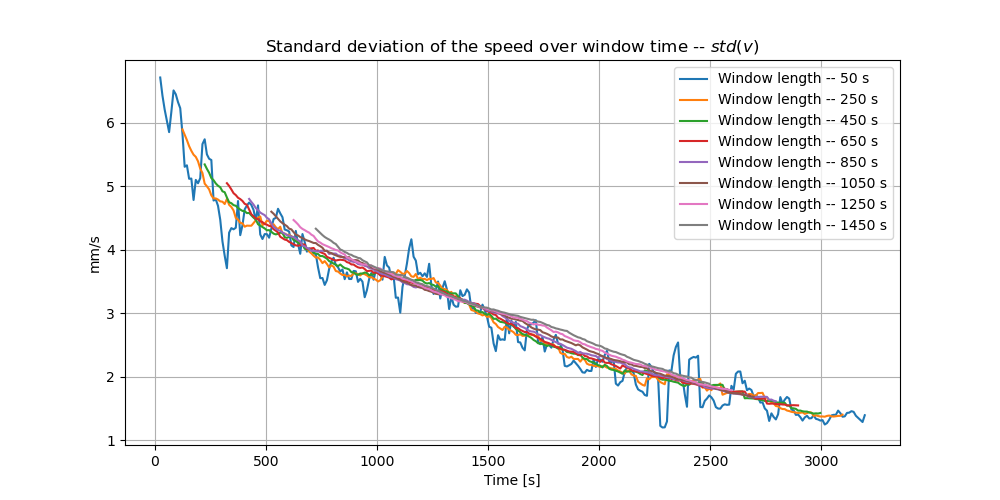

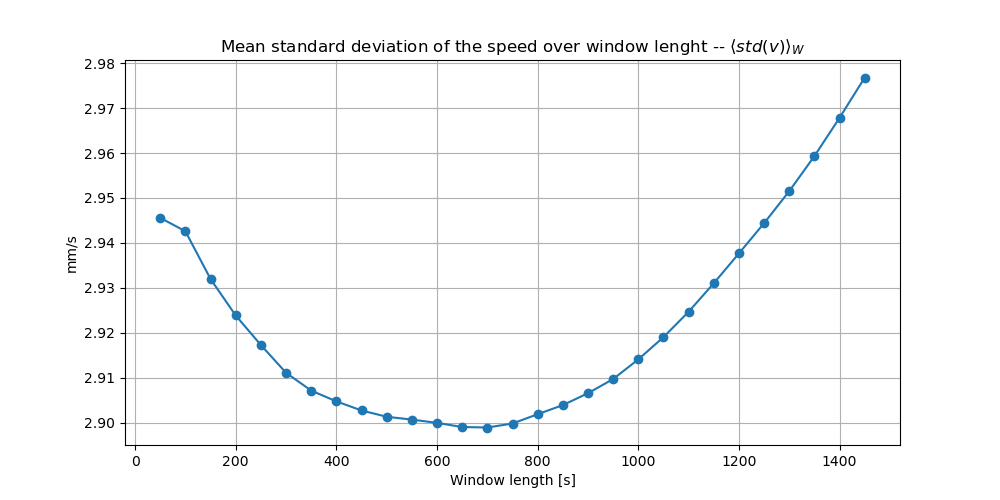

In [35]:
fig, ax = plt.subplots(1, 1, figsize = (10, 5))
for i, wind in enumerate(windLen):
    if i%4 == 0: ax.plot((startFrames[i] + wind/2*fps)/fps, std_v_wind[i], label = f'Window length -- {wind} s')
ax.grid()
ax.legend()
ax.set(xlabel = 'Time [s]', ylabel = f'{speed_units}', title = r'Standard deviation of the speed over window time -- $std(v)$')
plt.savefig(f'./{res_path}_300/std_v.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(1, 1, figsize = (10, 5))
ax.plot(windLen, [np.mean(std_v_wind[i]) for i in range(len(windLen))], '-o')
ax.grid()
ax.set(xlabel = 'Window length [s]', ylabel = f'{speed_units}', title = r'Mean standard deviation of the speed over window lenght -- $\langle std(v) \rangle_W$')
plt.savefig(f'./{res_path}_300/mean_std_v.pdf', bbox_inches='tight')
plt.show()

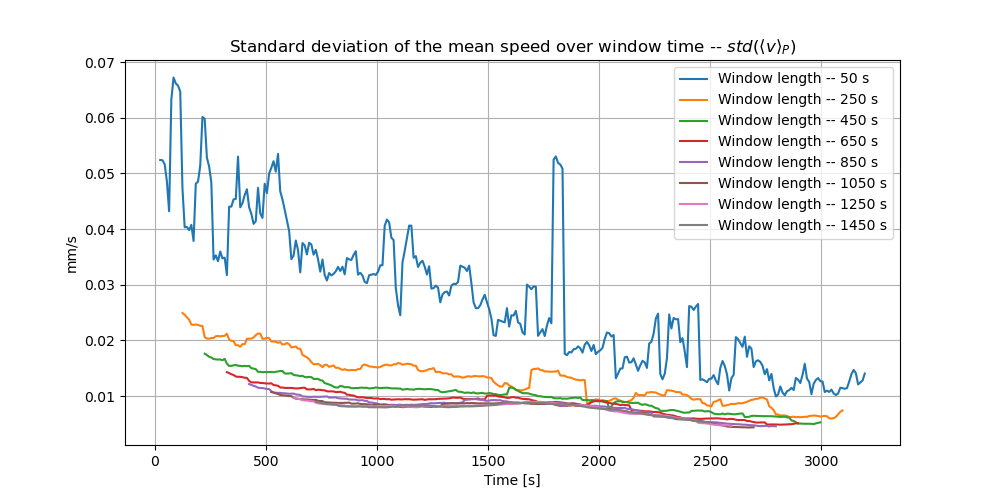

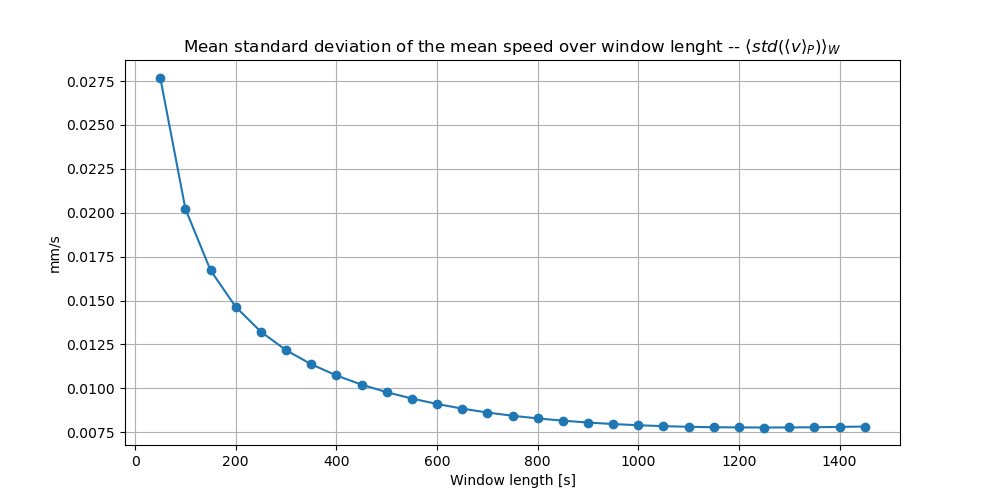

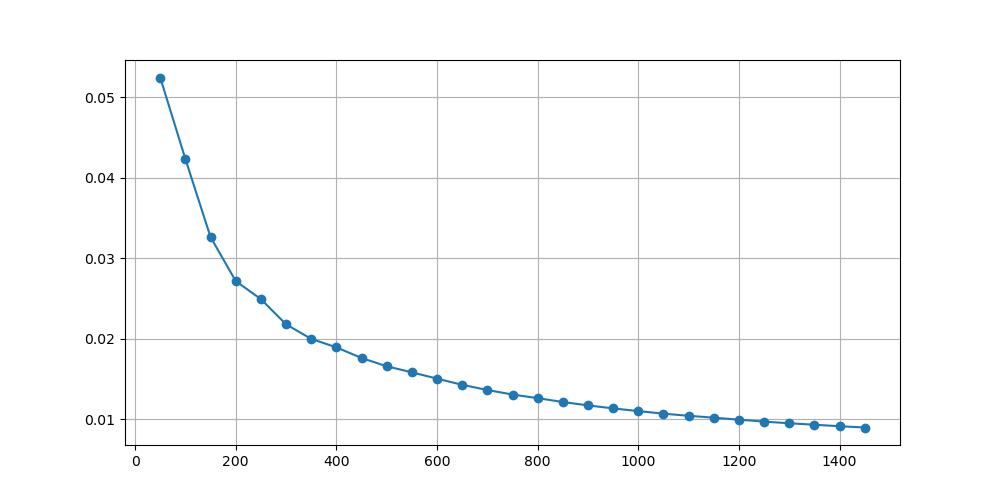

In [36]:
fig, ax = plt.subplots(1, 1, figsize = (10, 5))
for i, wind in enumerate(windLen):
    if i%4 == 0: ax.plot((startFrames[i] + wind/2*fps)/fps, std_v_mean_wind[i], label = f'Window length -- {wind} s')
ax.grid()
ax.legend()
ax.set(xlabel = 'Time [s]', ylabel = f'{speed_units}', title = r'Standard deviation of the mean speed over window time -- $std(\langle v \rangle_P)$')
plt.savefig(f'./{res_path}_300/window_lenght_analysis/std_mean_v.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(1, 1, figsize = (10, 5))
ax.plot(windLen, [np.mean(std_v_mean_wind[i]) for i in range(len(windLen))], '-o')
ax.set(xlabel = 'Window length [s]', ylabel = f'{speed_units}', title = r'Mean standard deviation of the mean speed over window lenght -- $\langle std(\langle v \rangle_P) \rangle_W$')
ax.grid()
plt.savefig(f'./{res_path}_300/window_lenght_analysis/mean_std_mean_v.pdf', bbox_inches='tight')
plt.show()


fig, ax = plt.subplots(1, 1, figsize = (10, 5))
ax.plot(windLen, [std_v_mean_wind[i][0] for i in range(len(windLen))], '-o')
ax.grid()
#plt.savefig(f'./{res_path}/window_lenght_analysis/mean_std_mean_v.pdf', bbox_inches='tight')
plt.show()

In [3]:
def run_windowed_analysis(windLen):
    startFrames_list, EMSD_wind_b_list, EMSD_wind_r_list, fit_dict_list, blue_fit_wind_turn_lorentzian_list, red_fit_wind_turn_lorentzian_list = [], [], [], [], [], []
    for wind in windLen:
        window = wind*fps # 300 s
        stride = 10*fps # 10 s
        startFrames = np.arange(frames[0], nFrames-window, stride, dtype=int)
        endFrames = startFrames + window
        nSteps = len(startFrames)
        
        if 1:
            MSD_wind, fit_wind, pw_exp_wind = get_imsd_windowed(nDrops, nSteps, startFrames, endFrames, trajectories, pxDimension, fps, maxLagtime, x_diffusive)
            EMSD_wind_b, EMSD_wind_r, fit_dict = get_emsd_windowed(MSD_wind, x_diffusive, fps, red_mask, nSteps, maxLagtime, x_diffusive)
            theta_blue_wind, theta_red_wind = turning_angles_windowed(nDrops, nSteps, startFrames, endFrames, red_particle_idx, trajectories, subsample_factor, fps)
            # fit windowed turning angles distributions with lorentzian distribution
            blue_fit_wind_turn_lorentzian = np.ones((nSteps, 2, 2))
            red_fit_wind_turn_lorentzian = np.ones((nSteps, 2, 2))
            for k in range(nSteps):
                blue_fit_wind_turn_lorentzian[k, 0], blue_fit_wind_turn_lorentzian[k, 1] = fit_hist(theta_blue_wind[k], bin_borders_turn, lorentzian_distr, [1., 0.])
                red_fit_wind_turn_lorentzian[k, 0], red_fit_wind_turn_lorentzian[k, 1] = fit_hist(theta_red_wind[k], bin_borders_turn, lorentzian_distr, [1., 0.])

        startFrames_list.append(startFrames)
        EMSD_wind_b_list.append(EMSD_wind_b)
        EMSD_wind_r_list.append(EMSD_wind_r)
        fit_dict_list.append(fit_dict)
        blue_fit_wind_turn_lorentzian_list.append(blue_fit_wind_turn_lorentzian)
        red_fit_wind_turn_lorentzian_list.append(red_fit_wind_turn_lorentzian)
    return startFrames_list, EMSD_wind_b_list, EMSD_wind_r_list, fit_dict_list, blue_fit_wind_turn_lorentzian_list, red_fit_wind_turn_lorentzian_list

In [5]:
window = 1500*fps # 300 s
stride = 10*fps # 10 s
startFrames = np.arange(frames[0], nFrames-window, stride, dtype=int)
endFrames = startFrames + window
nSteps = len(startFrames)
MSD_wind, fit_wind, pw_exp_wind = get_imsd_windowed(nDrops, nSteps, startFrames, endFrames, trajectories, pxDimension, fps, maxLagtime, x_diffusive)
EMSD_wind_b, EMSD_wind_r, fit_dict = get_emsd_windowed(MSD_wind, x_diffusive, fps, red_mask, nSteps, maxLagtime, x_diffusive)
theta_blue_wind, theta_red_wind = turning_angles_windowed(nDrops, nSteps, startFrames, endFrames, red_particle_idx, trajectories, subsample_factor, fps)

100%|██████████| 173/173 [00:11<00:00, 14.47it/s]
Traceback (most recent call last):
  File "/Users/matteoscandola/miniconda3/envs/pyenv/lib/python3.11/site-packages/joblib/externals/loky/backend/resource_tracker.py", line 281, in main
    registry[rtype][name] -= 1
    ~~~~~~~~~~~~~~~^^^^^^
KeyError: '/var/folders/zg/6m54bl917_3brnlpb7d2xgh00000gn/T/joblib_memmapping_folder_6771_1a64a6db82384714b78fbf227a80d438_98a974242276492eb34517dd7693266f/6771-5968488912-92cb7599e5964717aa8f412c1eb13644.pkl'
Traceback (most recent call last):
  File "/Users/matteoscandola/miniconda3/envs/pyenv/lib/python3.11/site-packages/joblib/externals/loky/backend/resource_tracker.py", line 281, in main
    registry[rtype][name] -= 1
    ~~~~~~~~~~~~~~~^^^^^^
KeyError: '/var/folders/zg/6m54bl917_3brnlpb7d2xgh00000gn/T/joblib_memmapping_folder_6771_1a64a6db82384714b78fbf227a80d438_98a974242276492eb34517dd7693266f/6771-5968488912-e42d490ab16d4aa5ac7e82db358db295.pkl'
100%|██████████| 173/173 [00:10<00:00, 17.11

In [6]:
windLen = np.arange(150, 1500, 50) #[110, 300, 600, 900, 1200, 1500, 1800, 2100]
bin_borders_turn = np.arange(-np.pi, np.pi + 0.0001, np.pi/50)
bin_centers_turn = bin_borders_turn[:-1] + np.diff(bin_borders_turn) / 2
x_interval_for_fit_turn = np.linspace(bin_borders_turn[0], bin_borders_turn[-1], 10000)

startFrames_list, EMSD_wind_b_list, EMSD_wind_r_list, fit_dict_list, blue_fit_wind_turn_lorentzian_list, red_fit_wind_turn_lorentzian_list = run_windowed_analysis(windLen)

100%|██████████| 303/303 [00:09<00:00, 32.10it/s]
Traceback (most recent call last):
  File "/Users/matteoscandola/miniconda3/envs/pyenv/lib/python3.11/site-packages/joblib/externals/loky/backend/resource_tracker.py", line 281, in main
    registry[rtype][name] -= 1
    ~~~~~~~~~~~~~~~^^^^^^
KeyError: '/var/folders/zg/6m54bl917_3brnlpb7d2xgh00000gn/T/joblib_memmapping_folder_6771_1a64a6db82384714b78fbf227a80d438_98a974242276492eb34517dd7693266f/6771-5968488912-92cb7599e5964717aa8f412c1eb13644.pkl'
Traceback (most recent call last):
  File "/Users/matteoscandola/miniconda3/envs/pyenv/lib/python3.11/site-packages/joblib/externals/loky/backend/resource_tracker.py", line 281, in main
    registry[rtype][name] -= 1
    ~~~~~~~~~~~~~~~^^^^^^
KeyError: '/var/folders/zg/6m54bl917_3brnlpb7d2xgh00000gn/T/joblib_memmapping_folder_6771_1a64a6db82384714b78fbf227a80d438_98a974242276492eb34517dd7693266f/6771-5968488912-e42d490ab16d4aa5ac7e82db358db295.pkl'
100%|██████████| 278/278 [00:15<00:00, 18.19

In [8]:
pw_exp_bins = np.linspace(0, 2, 100)
d_bins = np.linspace(0, 200, 100)

gamma_bins = np.linspace(0.2, 1, 100)

count_alpha_b = np.zeros((len(windLen), len(pw_exp_bins)-1))
count_alpha_r = np.zeros((len(windLen), len(pw_exp_bins)-1))
count_d_b = np.zeros((len(windLen), len(d_bins)-1))
count_d_r = np.zeros((len(windLen), len(d_bins)-1))
count_gamma_b = np.zeros((len(windLen), len(gamma_bins)-1))
count_gamma_r = np.zeros((len(windLen), len(gamma_bins)-1))

for i in range(len(windLen)):
    count_alpha_b[i], _ =  np.histogram(fit_dict_list[i]['pw_exp_wind_b'][:, 0, 1], bins=pw_exp_bins, density=True)
    count_alpha_r[i], _ =  np.histogram(fit_dict_list[i]['pw_exp_wind_r'][:, 0, 1], bins=pw_exp_bins, density=True)
    count_d_b[i], _     = np.histogram(fit_dict_list[i]['pw_exp_wind_b'][:, 0, 0], bins=d_bins, density=True)
    count_d_r[i], _     = np.histogram(fit_dict_list[i]['pw_exp_wind_r'][:, 0, 0], bins=d_bins, density=True)
    count_gamma_b[i], _ = np.histogram(blue_fit_wind_turn_lorentzian_list[i][:, 0, 0], bins=gamma_bins, density=True)
    count_gamma_r[i], _ = np.histogram(red_fit_wind_turn_lorentzian_list[i][:, 0, 0], bins=gamma_bins, density=True)

In [41]:
count_alpha_b.shape

(27, 99)

In [42]:
from scipy.stats import entropy


0.6025669074312547

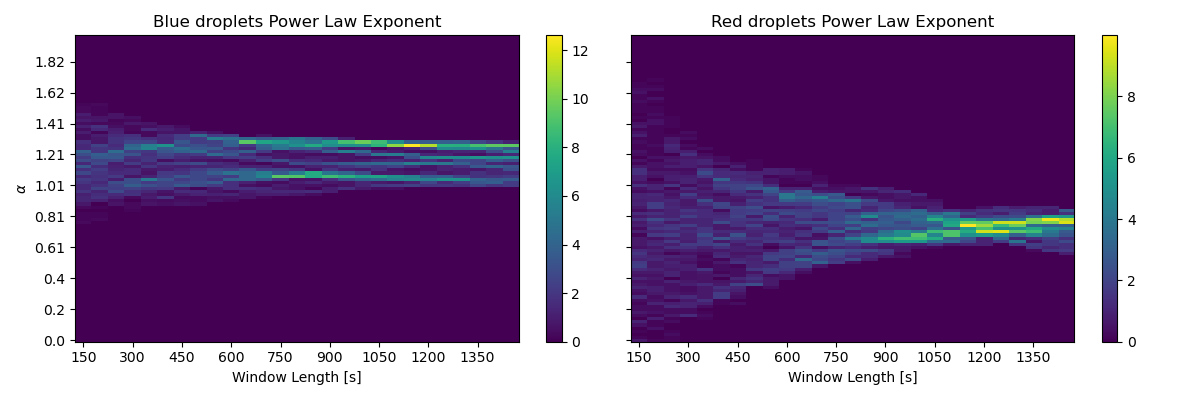

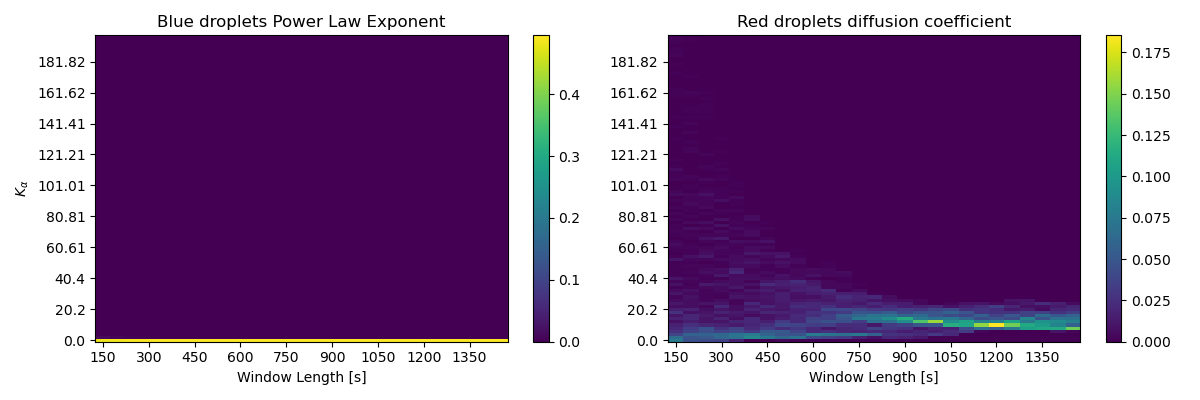

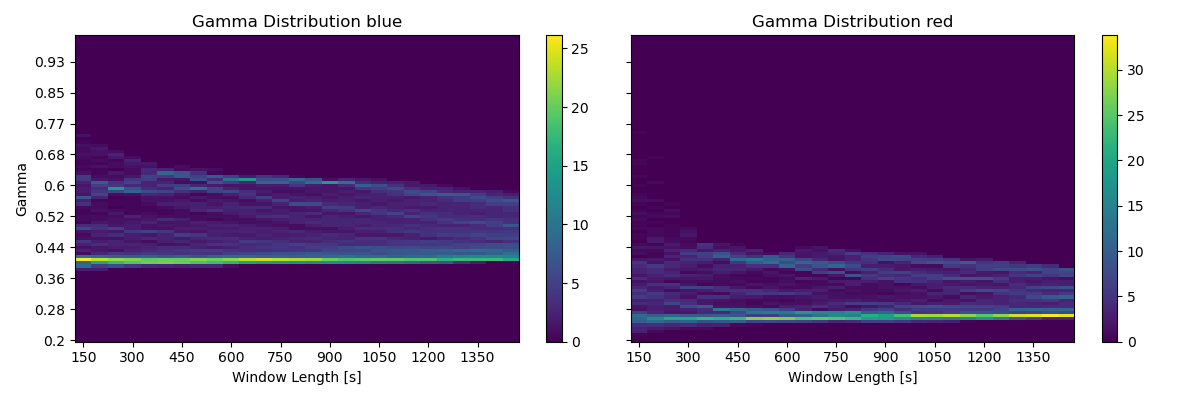

In [28]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)
img = ax.imshow(count_alpha_b.T, aspect='auto', cmap='viridis', origin='lower', interpolation='none')
ax.set_xlabel('Window Length [s]')
ax.set_ylabel(r'$\alpha$')
ax.set_title('Blue droplets Power Law Exponent')
ax.set_yticks(np.arange(len(pw_exp_bins))[::10])
ax.set_yticklabels(np.round(pw_exp_bins[::10], 2))
ax.set_xticks(range(len(windLen))[::3])
ax.set_xticklabels(windLen[::3])
plt.colorbar(img, ax = ax)

img = ax1.imshow(count_alpha_r.T, aspect='auto', cmap='viridis', origin='lower', interpolation='none')
ax1.set_xlabel('Window Length [s]')
ax1.set_title('Red droplets Power Law Exponent')
ax1.set_yticks(np.arange(len(pw_exp_bins))[::10])
ax1.set_yticklabels(np.round(pw_exp_bins[::10], 2))
ax1.set_xticks(range(len(windLen))[::3])
ax1.set_xticklabels(windLen[::3])
plt.colorbar(img, ax = ax1)
plt.tight_layout()
plt.savefig(f'{res_path}_300/window_lenght_analysis/pw_exp_windowed.pdf')
plt.show()

fig, (ax, ax1) = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=False)
img = ax.imshow(count_d_b.T, aspect='auto', cmap='viridis', origin='lower', interpolation='none')
ax.set_xlabel('Window Length [s]')
ax.set_ylabel(r'$K_\alpha$')
ax.set_title('Blue droplets Power Law Exponent')
ax.set_yticks(np.arange(len(d_bins))[::10])
ax.set_yticklabels(np.round(d_bins[::10], 2))
ax.set_xticks(range(len(windLen))[::3])
ax.set_xticklabels(windLen[::3])
plt.colorbar(img, ax = ax)

img = ax1.imshow(count_d_r.T, aspect='auto', cmap='viridis', origin='lower', interpolation='none')
ax1.set_xlabel('Window Length [s]')
ax1.set_title('Red droplets diffusion coefficient')
ax1.set_yticks(np.arange(len(d_bins))[::10])
ax1.set_yticklabels(np.round(d_bins[::10], 2))
ax1.set_xticks(range(len(windLen))[::3])
ax1.set_xticklabels(windLen[::3])
plt.colorbar(img, ax = ax1)
plt.tight_layout()
plt.savefig(f'{res_path}_300/window_lenght_analysis/diff_coeff_windowed.pdf')
plt.show()

fig, (ax, ax1) = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)
img = ax.imshow(count_gamma_b.T, aspect='auto', cmap='viridis', origin='lower', interpolation='none')
ax.set_xlabel('Window Length [s]')
ax.set_ylabel('Gamma')
ax.set_title('Gamma Distribution blue')
ax.set_yticks(np.arange(len(gamma_bins))[::10])
ax.set_yticklabels(np.round(gamma_bins[::10], 2))
ax.set_xticks(range(len(windLen))[::3])
ax.set_xticklabels(windLen[::3])
plt.colorbar(img, ax = ax)

img = ax1.imshow(count_gamma_r.T, aspect='auto', cmap='viridis', origin='lower', interpolation='none')
ax1.set_xlabel('Window Length [s]')
ax1.set_title('Gamma Distribution red')
ax1.set_yticks(np.arange(len(gamma_bins))[::10])
ax1.set_yticklabels(np.round(gamma_bins[::10], 2))
ax1.set_xticks(range(len(windLen))[::3])
ax1.set_xticklabels(windLen[::3])
plt.colorbar(img, ax = ax1)
plt.tight_layout()
plt.savefig(f'{res_path}_300/window_lenght_analysis/turn_angles_windowed.pdf')
plt.show()

shannon entropy as a function of the window length

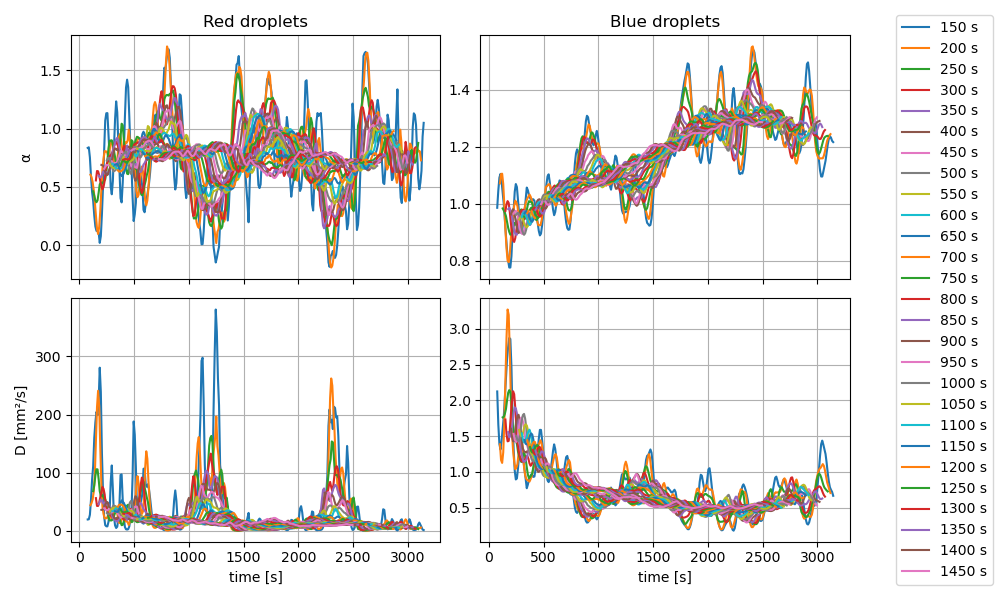

In [29]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6), sharex=True)    
for i, wind in enumerate(windLen):
    alpha_r = fit_dict_list[i]['pw_exp_wind_r'][:, 0, 1]
    alpha_b = fit_dict_list[i]['pw_exp_wind_b'][:, 0, 1]
    D_r = fit_dict_list[i]['pw_exp_wind_r'][:, 0, 0]
    D_b = fit_dict_list[i]['pw_exp_wind_b'][:, 0, 0]
    ax[0, 0].plot((startFrames_list[i] + wind*fps/2)/fps, alpha_r, label=f'{windLen[i]} s', color=f'C{i}')
    ax[0, 1].plot((startFrames_list[i] + wind*fps/2)/fps, alpha_b, color=f'C{i}')
    ax[1, 0].plot((startFrames_list[i] + wind*fps/2)/fps, D_r, color=f'C{i}')
    ax[1, 1].plot((startFrames_list[i] + wind*fps/2)/fps, D_b, color=f'C{i}')
ax[0, 0].set(ylabel = 'α', title='Red droplets')
ax[0, 0].grid()
ax[0, 1].set( title='Blue droplets')
ax[0, 1].grid()
ax[1, 0].set(ylabel = 'D [mm²/s]', xlabel='time [s]')
ax[1, 0].set(xlabel = 'time [s]')
ax[1, 0].grid()
ax[1, 1].set(xlabel = 'time [s]')
ax[1, 1].grid()
plt.tight_layout()
fig.legend(loc=7)
fig.tight_layout()
fig.subplots_adjust(right=0.85)
plt.savefig(f'./{res_path}_300/window_lenght_analysis/windowed_analysis_emsd.pdf')
plt.show()

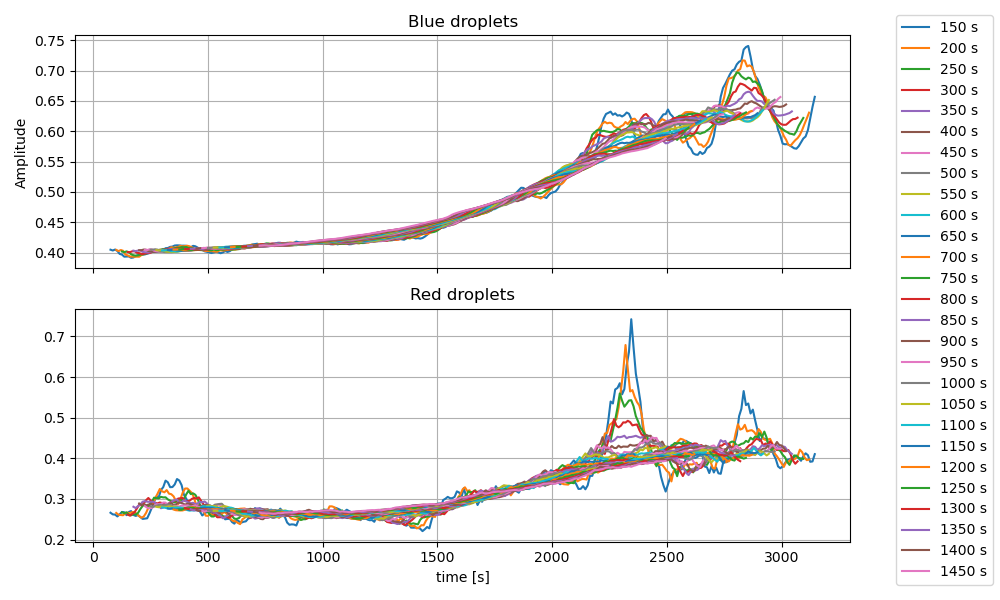

In [30]:
fig, (ax, ax1) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)    
for i, wind in enumerate(windLen):
    ax.plot((startFrames_list[i] + wind*fps/2)/fps, blue_fit_wind_turn_lorentzian_list[i][:, 0, 0], label=f'{windLen[i]} s', color=f'C{i}')
    ax1.plot((startFrames_list[i] + wind*fps/2)/fps, red_fit_wind_turn_lorentzian_list[i][:, 0, 0], color=f'C{i}')
ax.set(ylabel = 'Amplitude', title='Blue droplets')
ax.grid()
ax1.set( title='Red droplets')
ax1.grid()
ax1.set(xlabel = 'time [s]')
plt.tight_layout()
fig.legend(loc=7)
fig.tight_layout()
fig.subplots_adjust(right=0.85)
plt.savefig(f'./{res_path}_300/window_lenght_analysis/windowed_analysis_turning_angles.pdf')
plt.show()